<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

# Worksheet 3.2 FSGM Attack on Image Classifier

In this lab, you'll perform a **Fast Gradient Sign Method (FGSM)** attack on a simple CIFAR-10 classifier.  
The goal is to see how small, human-imperceptible perturbations can cause misclassification.  The goal here is not to focus on training neural networks, so we will give you all the code to train the image classifier.

For this exercise, we'll be using the CIFAR-10 dataset (https://en.wikipedia.org/wiki/CIFAR-10) which is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

---

## Learning Objectives
- Understand how FGSM generates adversarial examples.
- Use the **Adversarial Robustness Toolbox (ART)** to run attacks.
- Measure model accuracy under attack for different perturbation sizes (ε).
- Visualize adversarial examples and perturbations.
- Reflect on implications for ML security.



## Step 1: Setup & Imports
Run this section first!

In [2]:

# Install if needed (uncomment for Colab or fresh envs)
# !pip install torch torchvision matplotlib adversarial-robustness-toolbox

import os, random, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

# Reproducibility
seed = 1337
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


/Users/charlesgivre/.conda/envs/data-prep/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu



## Step 2: Load CIFAR-10 (subset for speed)

We’ll use only **2,000 training images** and **1,000 test images** to keep runtime short.  If you have a GPU, can set these numbers to higher values to see more images.


In [4]:

N_TRAIN_SUBSET = 2000
N_TEST_SUBSET  = 1000
BATCH_TRAIN    = 128
BATCH_TEST     = 256

transform = transforms.ToTensor()
train_full = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_full  = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_ds = Subset(train_full, list(range(N_TRAIN_SUBSET)))
test_ds  = Subset(test_full,  list(range(N_TEST_SUBSET)))

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False)

print("Train subset size:", len(train_ds))
print("Test subset size:", len(test_ds))


Files already downloaded and verified
Files already downloaded and verified
Train subset size: 2000
Test subset size: 1000



## Step 3: Define and Train a Tiny CNN

A small CNN trains quickly on CPU. We’ll do **1 epoch** for a demo.  You can increase the number of epochs for higher accuracy, but the speed will be significantly slower.


In [6]:

class TinyCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = TinyCIFAR().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=2e-3)

def train_one_epoch():
    model.train(); total = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = nn.CrossEntropyLoss()(model(x), y)
        loss.backward(); opt.step()
        total += loss.item() * y.size(0)
    return total / len(train_loader.dataset)

@torch.no_grad()
def accuracy(loader):
    model.eval(); c=t=0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        c += (model(x).argmax(1) == y).sum().item()
        t += y.size(0)
    return c/t

print("Training...")
# Increase the number of epochs for greater accuracy.
for epoch in range(1):
    tr_loss = train_one_epoch()
    te_acc  = accuracy(test_loader)
    print(f"Epoch {epoch+1} | train_loss={tr_loss:.4f} | test_acc={te_acc:.3f}")

print("Final clean test accuracy:", accuracy(test_loader))


Training...
Epoch 2 | train_loss=2.2704 | test_acc=0.224
Epoch 3 | train_loss=2.0192 | test_acc=0.351
Epoch 4 | train_loss=1.8206 | test_acc=0.347
Epoch 5 | train_loss=1.6768 | test_acc=0.377
Final clean test accuracy: 0.377



## Step 4: Wrap Model with ART Classifier

Now that we have a trained model, we can wrap the model using ART's PyTorchClassifier (https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/estimators/classification.html#pytorch-classifier). This acts as an abstraction for the classifier and we'll use this to build the attack.  


In [12]:
# Wrap the classifer in the ART PyTorchClassifier
classifier = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    optimizer=opt,
    input_shape=(3,32,32),
    nb_classes=10,
    clip_values=(0.0, 1.0),
    preprocessing=(0.0, 1.0)
)

# Check the accuracy without any adversarial examples. 
def art_accuracy(loader):
    correct = total = 0
    for x, y in loader:
        preds = classifier.predict(x.numpy(), batch_size=BATCH_TEST).argmax(axis=1)
        correct += (preds == y.numpy()).sum()
        total   += y.size(0)
    return correct/total

print("Clean test accuracy (ART view):", art_accuracy(test_loader))


Clean test accuracy (ART view): 0.377


## Step 5: FGSM Attack Sweep
Now we have a trainined classifer and we can see how accurate this model is.  We’ll measure adversarial accuracy for different epsilon values.  

Epsilon is the parameter that controls the magnitude of the perturbation you add to the input image.
Think of epsilon as the "strength knob" for the attack.

* A small epsilon means the perturbation is very difficult for a human to notice, but it may only slightly fool the model (or not at all).
* A large epsilon means the perturbation is easier for the model to misclassify, but also more visible to humans.

L∞ (L-infinity) in the context of adversarial attacks like FGSM, they’re talking about a way to measure the size of the perturbation that was added to an input.


ε=0.00784 | adv_acc=0.368 | clean_acc=0.377
ε=0.01569 | adv_acc=0.324 | clean_acc=0.377
ε=0.03137 | adv_acc=0.247 | clean_acc=0.377
ε=0.04706 | adv_acc=0.193 | clean_acc=0.377


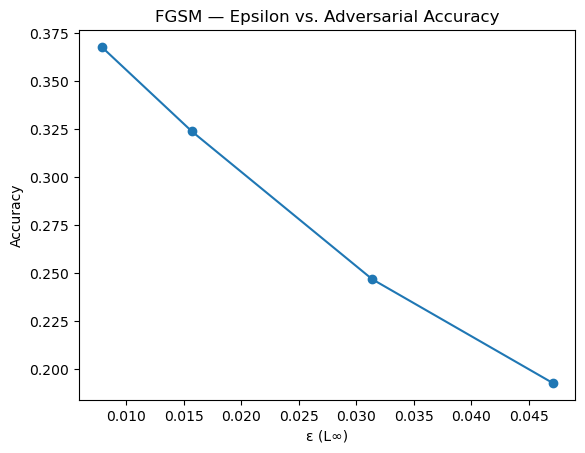

In [15]:

EPS_LIST = [2/255, 4/255, 8/255, 12/255]

# Check accuracy with 
def adv_accuracy_fgsm(eps):
    atk = FastGradientMethod(estimator=classifier, eps=eps, norm=np.inf, targeted=False)
    correct = total = 0
    for x, y in test_loader:
        x_adv = atk.generate(x.numpy())
        preds = classifier.predict(x_adv, batch_size=BATCH_TEST).argmax(axis=1)
        correct += (preds == y.numpy()).sum()
        total   += y.size(0)
    return correct / total

clean_acc = art_accuracy(test_loader)
results = []


for eps in EPS_LIST:
    adv_acc = adv_accuracy_fgsm(eps)
    results.append((eps, adv_acc))
    print(f"ε={eps:.5f} | adv_acc={adv_acc:.3f} | clean_acc={clean_acc:.3f}")

# Plot
plt.figure()
plt.title("FGSM — Epsilon vs. Adversarial Accuracy")
plt.plot([r[0] for r in results], [r[1] for r in results], marker='o')
plt.xlabel("ε (L∞)"); plt.ylabel("Accuracy")
plt.show()



## Step 6: Visualize Adversarial Images

We’ll compare:  
- Clean images (top)  
- Adversarial images (middle)  
- Perturbation ×10 (bottom)


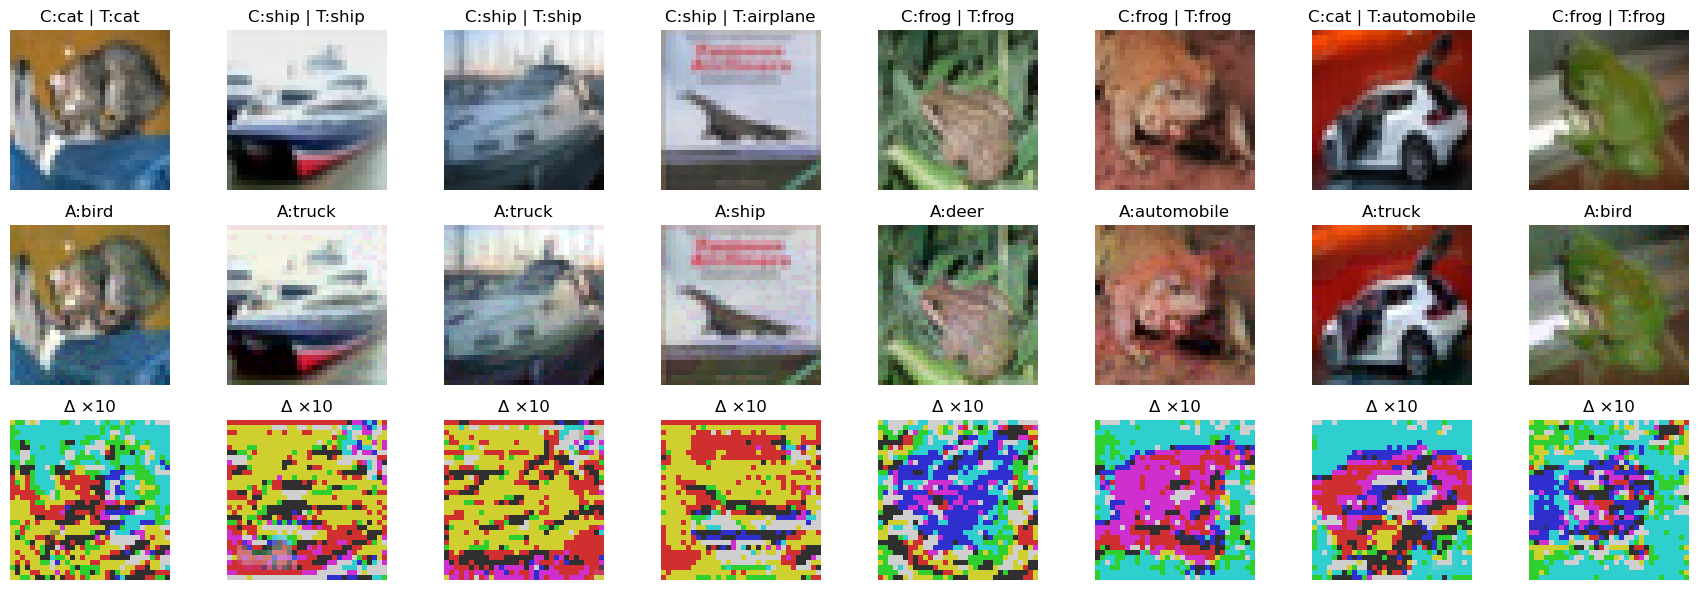

In [25]:

CIFAR10_LABELS = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def make_adversarials(x_np, eps):
    atk = FastGradientMethod(estimator=classifier, eps=eps, norm=np.inf, targeted=False)
    return atk.generate(x=x_np)

def show_grid(num=8, eps=8/255):
    x, y = next(iter(test_loader))
    x, y = x[:num].numpy(), y[:num].numpy()
    preds_clean = classifier.predict(x).argmax(axis=1)
    x_adv = make_adversarials(x, eps)
    preds_adv = classifier.predict(x_adv).argmax(axis=1)
    delta = x_adv - x

    fig, axes = plt.subplots(3, num, figsize=(2.2*num, 6))
    for i in range(num):
        # Clean image
        axes[0, i].imshow(np.transpose(x[i], (1, 2, 0)))
        axes[0, i].set_title(f"C:{CIFAR10_LABELS[preds_clean[i]]} | T:{CIFAR10_LABELS[y[i]]}")
        axes[0, i].axis('off')

        # Adversarial
        axes[1, i].imshow(np.transpose(x_adv[i], (1, 2, 0)))
        axes[1, i].set_title(f"A:{CIFAR10_LABELS[preds_adv[i]]}")
        axes[1, i].axis('off')

        # Perturbation ×10
        pert = np.clip(10 * delta[i] + 0.5, 0, 1)
        axes[2, i].imshow(np.transpose(pert, (1, 2, 0)))
        axes[2, i].set_title("Δ ×10")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()


# Demo
show_grid(num=8, eps=8/255)



## Step 7: (Optional) Targeted FGSM

Try forcing predictions into a specific target class (e.g., "bird").


Targeted FGSM to 'bird' success rate: 0.444


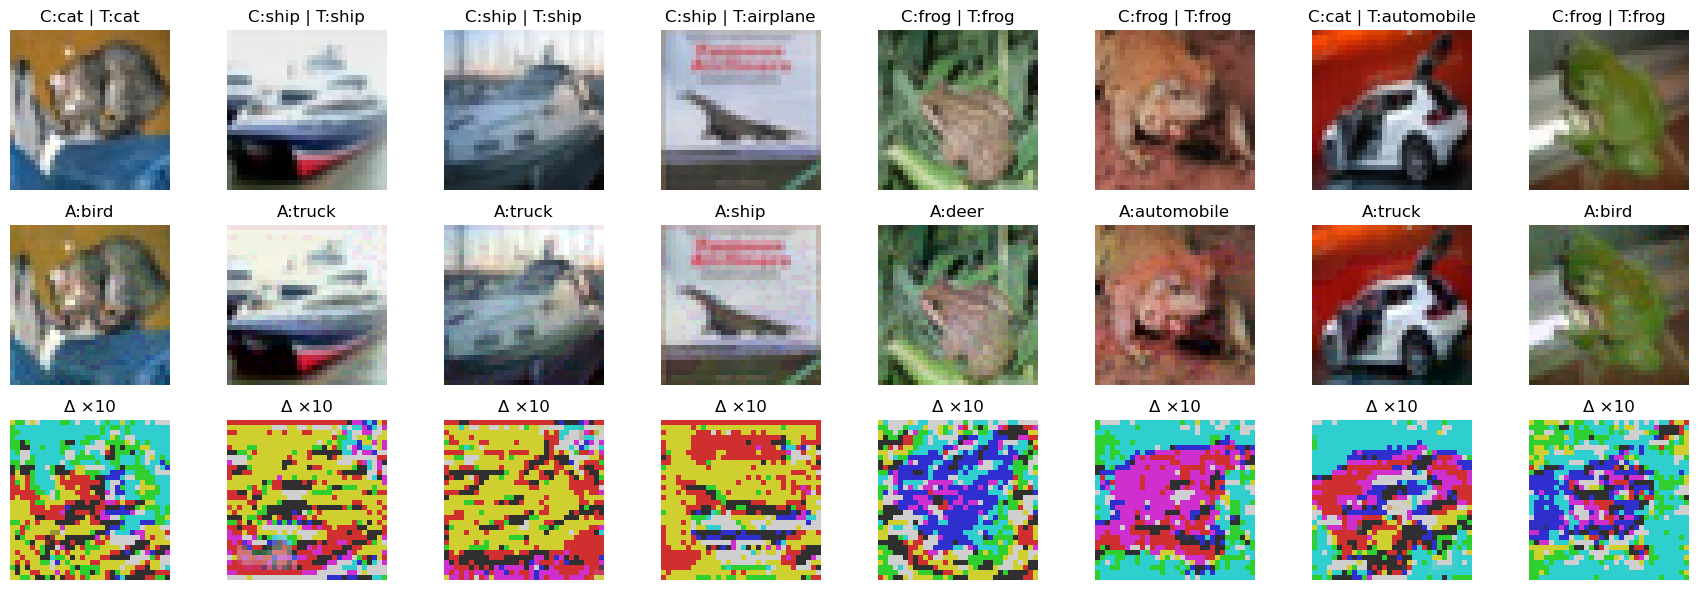

In [27]:

target_class = 2  # bird
eps_t = 8/255
atk_t = FastGradientMethod(estimator=classifier, eps=eps_t, norm=np.inf, targeted=True)
correct_targets = total = 0
for x, _ in test_loader:
    y_t = np.full((x.size(0),), target_class, dtype=np.int64)
    x_adv_t = atk_t.generate(x.numpy(), y=y_t)
    preds_t = classifier.predict(x_adv_t).argmax(axis=1)
    correct_targets += (preds_t == y_t).sum()
    total += y_t.shape[0]
print(f"Targeted FGSM to '{CIFAR10_LABELS[target_class]}' success rate: {correct_targets/total:.3f}")

show_grid(num=8, eps=eps_t)



## Step 8: Reflection Questions

- How does increasing ε affect adversarial accuracy?  
- At what epsilon do perturbations become visible to the human eye?  
- Compare untargeted vs targeted attacks: which is harder to achieve?  
- What defenses might help against FGSM?  
